In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision.models.video import swin_transformer

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [4]:
dirpath = 'Cardiac-Video-Sequence/' # Change to location of this folder on your device
X = torch.load(dirpath+'X_tensor.pt')
Y = torch.load(dirpath+'Y_tensor.pt')

In [5]:
class TOCDataset(Dataset):
    def __init__(self, X, Y):
        """
        X: torch.Tensor of shape (N, 25, 80, 80) - videos
        Y: torch.Tensor of shape (N, 126) - target curves
        """
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Expand to 3 channels by repeating along the channel dimension
        video = self.X[idx]#.unsqueeze(0).repeat(3, 1, 1, 1)  # Shape: (3, 25, 80, 80)
        curve = self.Y[idx]
        return video, curve

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class VideoToCurveModel(nn.Module):
    def __init__(self):
        super(VideoToCurveModel, self).__init__()
        
        # 3D convolution layers to extract spatio-temporal features
        self.conv1 = nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        
        # Fully connected layers for regression
        self.fc1 = nn.Linear(153600, 512)  # Calculate the input size based on the pooling output
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 126)  # Output layer with 126 points

    def forward(self, x):
        # Apply the first convolutional layer
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        # Apply the second convolutional layer
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        # Flatten the output of the last convolutional layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        #print(x.shape)
        
        # Apply fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)  # Final output (126 curve points)
        
        return x

In [7]:
# Create dataset and data loader
dataset = TOCDataset(X, Y)
#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
bs = 8

train_dataset = dataset#, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [8]:
model = VideoToCurveModel()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [10]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup
patience = 5
best_train_loss = float('inf')
patience_counter = 0
best_model_weights = None

# Training loop
num_epochs = 250
model.train()
for epoch in range(num_epochs):
    # Initialize variables to track loss and progress
    epoch_loss = 0.0
    
    for inputs, labels in train_loader:
        # Add a channel dimension if not already present (assuming inputs are of shape [batch_size, 25, 80, 80])
        inputs = inputs.unsqueeze(1)  # Shape becomes [batch_size, 1, 25, 80, 80]
        
        # Move to the device (GPU or CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print average loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)
    #print(f"Epoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")

    # Early stopping logic
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        patience_counter = 0
        best_model_weights = model.state_dict()  # Save the best model weights
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Validation loss did not improve for {patience} epochs.")
            break
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs} loss: {avg_train_loss}")

# Restore the best model weights after training
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Restored the best model weights.")


Epoch 0/250 loss: 495.23087201799666
Epoch 5/250 loss: 213.71180997576033
Epoch 10/250 loss: 160.8627482822963
Epoch 15/250 loss: 122.11978149414062
Epoch 20/250 loss: 73.29196112496513
Epoch 25/250 loss: 49.04011453901018
Epoch 30/250 loss: 22.581050940922328
Epoch 35/250 loss: 15.129864999226161
Epoch 40/250 loss: 14.429580688476562
Epoch 45/250 loss: 10.982115047318596
Early stopping triggered. Validation loss did not improve for 5 epochs.
Restored the best model weights.


In [38]:
def plot_predictions(predictions, ground_truths, num_samples=16):
    num_samples = min(num_samples, len(predictions))
    indices = torch.randint(0, len(predictions), (num_samples,))  # Randomly select samples
    
    # Create a 5x5 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier

    for i, idx in enumerate(indices):
        ax = axes[i]  # Get the current subplot axis
        ax.plot(ground_truths[idx].numpy(), label="True Curve", linestyle='--')
        ax.plot(predictions[idx].numpy(), label="Predicted Curve", linestyle='-')
        ax.set_title(f"Sample {i + 1}")
        ax.legend()
        ax.grid(True)
        #ax.set_xticks([])
        #ax.set_yticks([])
    
    # Adjust the layout to avoid overlapping
    plt.tight_layout()
    
    plt.show()

# Example usage
# Assuming `predictions` and `ground_truths` are tensors of shape (N, 126)
# plot_predictions(predictions, ground_truths, num_samples=25)


# Function to evaluate the model on the test set and compute both MSE and R²
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_mse = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for videos, curves in test_loader:
            videos = videos.unsqueeze(1)
            videos, curves = videos.to(device), curves.to(device)
            
            
            # Forward pass
            outputs = model(videos)
            
            # Accumulate predictions and ground truth for plotting
            predictions.append(outputs.cpu())
            ground_truths.append(curves.cpu())
            
            # Compute MSE for the batch
            total_mse += nn.MSELoss()(outputs, curves).item()

    # Concatenate predictions and ground truths for plotting
    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)

    # Compute average MSE
    avg_mse = total_mse / len(test_loader)

    # Compute R² score
    r2 = r2_score(ground_truths.numpy(), predictions.numpy())

    return avg_mse, r2, predictions, ground_truths


Test MSE: 16.3074
Test R²: -263.6149


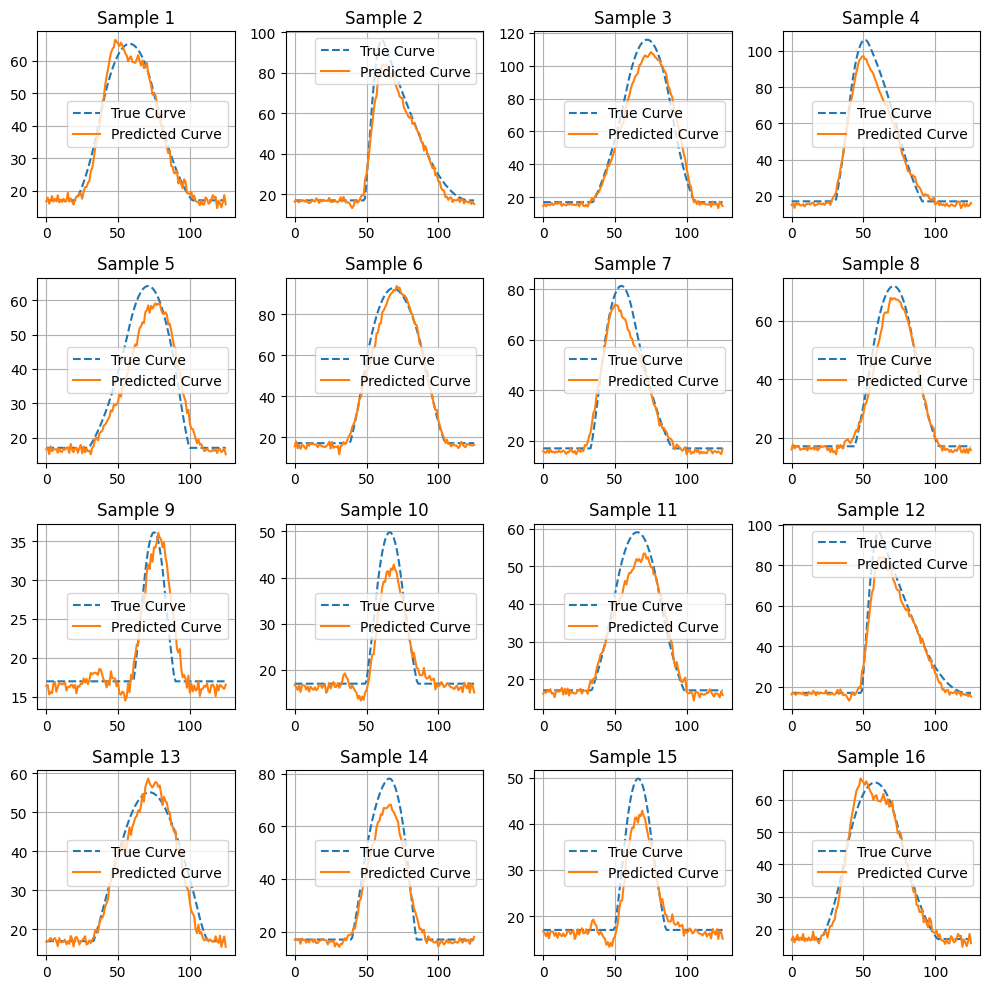

In [39]:
# Example usage
test_mse, r2,  predictions, ground_truths = evaluate_model(model, train_loader, device)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {r2:.4f}")

# Optionally, plot the predicted vs true curves
plot_predictions(predictions, ground_truths)


In [43]:
model.eval()  # Set the model to evaluation mode
total_mse = 0
predictions = []
ground_truths = []
mse_tracking = []

with torch.no_grad():
    ind = 0
    for videos, curves in train_dataset:
        videos = videos.unsqueeze(1)
        videos, curves = videos.to(device), curves.to(device)


        # Forward pass
        outputs = model(videos)

        # Accumulate predictions and ground truth for plotting
        predictions.append(outputs.cpu())
        ground_truths.append(curves.cpu())

        # Compute MSE for the batch
        total_mse += nn.MSELoss()(outputs, curves).item()
        mse_tracking.append(nn.MSELoss()(outputs, curves).item())

# Concatenate predictions and ground truths for plotting
predictions = torch.cat(predictions, dim=0)
ground_truths = torch.cat(ground_truths, dim=0)

# Compute R² score
#r2 = r2_score(ground_truths.numpy(), predictions.numpy())

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3, 3], expected input[1, 25, 1, 80, 80] to have 1 channels, but got 25 channels instead

In [42]:
mse_tracking

[26.830698013305664,
 8.707996368408203,
 7.8792924880981445,
 16.447538375854492,
 15.362626075744629,
 20.176687240600586,
 16.168041229248047,
 22.661029815673828,
 15.10763931274414,
 21.27125358581543,
 16.670398712158203,
 17.255409240722656,
 12.701090812683105,
 11.064143180847168]

In [45]:
for i,j in train_dataset:
    print(i.shape, j.shape)
    break

torch.Size([25, 80, 80]) torch.Size([126])
